# Import Libraries

In [37]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from matplotlib import cm
import numpy as np
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Obtain Data

In [14]:
df = pd.read_csv('data/data.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Scrub Data

Perform df.info() to understand what data scrubbing needed

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Drop columns not needed for modeling

In [16]:
df.drop(columns=['id', 'keyword', 'location'], inplace=True)
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Pre-Process Data

Tokenize disaster and non-disaster classes

In [17]:
disaster_reviews = df[df['target']==1]['text'].values
disaster_tokens = []
for disaster_review in disaster_reviews:
    split_disaster_review = disaster_review.split()
    for disaster_word in split_disaster_review:
        disaster_tokens.append(disaster_word)
        
non_disaster_reviews = df[df['target']==0]['text'].values
non_disaster_tokens = []
for non_disaster_review in non_disaster_reviews:
    split_non_disaster_review = non_disaster_review.split()
    for non_disaster_word in split_non_disaster_review:
          non_disaster_tokens.append(non_disaster_word)

Remove stopwords from disaster and non-disaster tokens

In [20]:
stopwords_list = stopwords.words('english')
stopwords_list.extend(['-','the', 'i', 'a', 'an'])

def remove_stopwords(input_list, stopwords_list):
    return_list = []
    for word in input_list:
        if word not in stopwords_list:
            return_list.append(word)
    return return_list

filtered_disaster_tokens = remove_stopwords(disaster_tokens, stopwords_list)
filtered_non_tokens = remove_stopwords(non_disaster_tokens, stopwords_list)


Stem disaster and non-disaster tokens

In [22]:
stemmer = SnowballStemmer('english')
stemmed_disaster = [stemmer.stem(word) for word in filtered_disaster_tokens]
stemmed_non = [stemmer.stem(word) for word in filtered_non_tokens]

# Explore Data

Calculate class balance

In [23]:
num_disaster_reviews = len(df[df['target'] == 1]['target'].values)
num_non_reviews = len(df[df['target'] == 0]['target'].values)
total_reviews = num_disaster_reviews + num_non_reviews

print('Distaster Reviews: ', num_disaster_reviews)
print('Non Distaster Reviews: ', num_non_reviews)
print('Total Reviews: ', num_disaster_reviews + num_non_reviews)

print('Distaster Review Proportion: ', num_disaster_reviews/total_reviews)
print('Non Distaster Review Propotion: ', num_non_reviews/total_reviews)


Distaster Reviews:  3271
Non Distaster Reviews:  4342
Total Reviews:  7613
Distaster Review Proportion:  0.4296597924602653
Non Distaster Review Propotion:  0.5703402075397347


Plot class balance

Text(0, 0.5, 'Count')

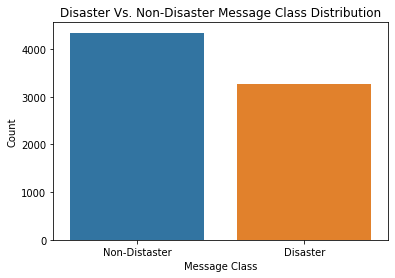

In [54]:
fig, ax = plt.subplots()
sns.countplot(x='target', data=df, ax=ax)
ax.set_title('Disaster Vs. Non-Disaster Message Class Distribution')
ax.set_xlabel('Message Class')
ax.set_xticklabels(['Non-Distaster', 'Disaster'])
ax.set_ylabel('Count')

Calculate 25 most frequent words by class

In [25]:
disaster_freq = FreqDist(stemmed_disaster)
non_freq = FreqDist(stemmed_non)

disaster_freq_words = [x[0] for x in disaster_freq.most_common(25)]
disaster_freq_counts = [x[1] for x in disaster_freq.most_common(25)]
non_freq_words = [x[0] for x in non_freq.most_common(25)]
non_freq_counts = [x[1] for x in non_freq.most_common(25)]

Plot frequency distributions of 25 most common words by class

Text(0, 0.5, 'Frequency')

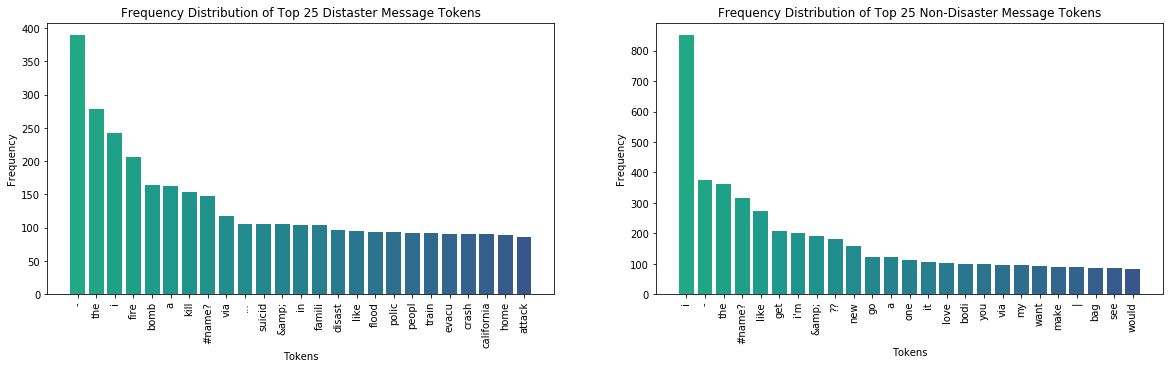

In [11]:
color = cm.viridis_r(np.linspace(.4,.8, 30))
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(20,5))
ax[0].bar(disaster_freq_words, disaster_freq_counts, color=color)
ax[0].set_xticklabels(labels=disaster_freq_words, rotation=90)
ax[0].set_title('Frequency Distribution of Top 25 Distaster Message Tokens')
ax[0].set_xlabel('Tokens')
ax[0].set_ylabel('Frequency')
ax[1].bar(non_freq_words, non_freq_counts, color=color)
ax[1].set_xticklabels(labels=non_freq_words, rotation=90)
ax[1].set_title('Frequency Distribution of Top 25 Non-Disaster Message Tokens')
ax[1].set_xlabel('Tokens')
ax[1].set_ylabel('Frequency')

Plot word cloud of frequency distributions of 25 most common words by class

[]

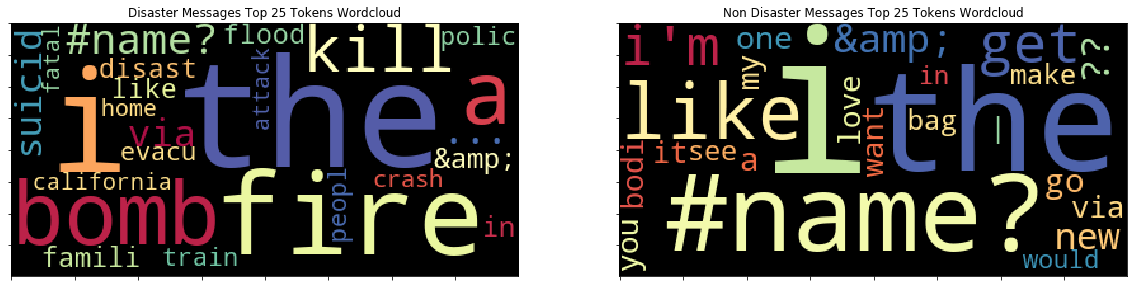

In [26]:
disaster_freq_zipped = dict(zip(disaster_freq_words, disaster_freq_counts))
non_freq_zipped = dict(zip(non_freq_words, non_freq_counts))
disaster_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(disaster_freq_zipped)
non_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(non_freq_zipped)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
ax[0].imshow(disaster_wordcloud)
ax[0].set_title('Disaster Messages Top 25 Tokens Wordcloud')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].imshow(non_wordcloud)
ax[1].set_title('Non Disaster Messages Top 25 Tokens Wordcloud')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# Model Data

Create x and y variables

In [27]:
x = df['text']
y = df['target']

Train test split x and y variables

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=37, train_size = .2)

Vectorize x variable text data using tf-idf

In [29]:
vectorizer = TfidfVectorizer(stop_words = stopwords_list)
vectorizer.fit(x_train)
tfidf_x_train = vectorizer.transform(x_train)
tfidf_x_test = vectorizer.transform(x_test)

Build baseline dummy classifier

In [30]:
dummy = DummyClassifier(random_state=22)
dummy.fit(tfidf_x_train, y_train)
y_train_pred_dummy = dummy.predict(tfidf_x_train)
y_test_pred_dummy = dummy.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_dummy))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_dummy))

Train F1 Score:  0.41864139020537117
Test F1 Score:  0.4270833333333333


/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Gridsearch optimal Naive Bayes model

In [31]:
nb_dict = {'alpha': [x/1000 for x in range(200,400)]}
nb_model = MultinomialNB()
gs_nb = GridSearchCV(nb_model, nb_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_nb.fit(tfidf_x_train, y_train)
gs_nb.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.8s finished


{'alpha': 0.294}

Fit optimal Naive Bayes model

In [32]:
nb = MultinomialNB(alpha=.294)
nb.fit(tfidf_x_train, y_train)
y_train_pred = nb.predict(tfidf_x_train)
y_test_pred = nb.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred))
print('Test F1 Score: ', f1_score(y_test, y_test_pred))

Train F1 Score:  0.9534510433386838
Test F1 Score:  0.7022149302707137


Create Naive Bayes Confusion Matrix

[Text(0, 0.5, 'Non-Disaster'), Text(0, 1.5, 'Disaster')]

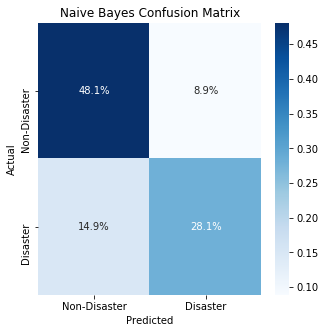

In [33]:
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Naive Bayes Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Non-Disaster','Disaster'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Non-Disaster','Disaster'])

Gridsearch optimal Adaboost model

In [35]:
ab_dict = {'learning_rate': [x/10 for x in range(0,11)], 'n_estimators': [100, 250, 500]}
ab_model = AdaBoostClassifier()
gs_ab = GridSearchCV(ab_model, ab_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_ab.fit(tfidf_x_train, y_train)
gs_ab.best_params_

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:  4.8min finished


{'learning_rate': 0.9, 'n_estimators': 500}

Fit optimal Adaboost model

In [36]:
ab = AdaBoostClassifier(learning_rate=.9, n_estimators=500)
ab.fit(tfidf_x_train, y_train)
y_train_pred_ab = ab.predict(tfidf_x_train)
y_test_pred_ab = ab.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_ab))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_ab))

Train F1 Score:  0.9731012658227848
Test F1 Score:  0.6367820692415449


Gridsearch xgboost model

In [49]:
xgb_dict = {'max_depth': range(4,8), 'learning_rate': [x/10 for x in range(2,7)], 
            'reg_alpha': [x/10 for x in range(7,10)], 'gamma': [x/10 for x in range(5,16,2)]}
gs_xgb = XGBClassifier()
gs_xgb = GridSearchCV(gs_xgb, xgb_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_xgb.fit(tfidf_x_train, y_train)
gs_xgb.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  9.5min finished


{'gamma': 0.9, 'learning_rate': 0.5, 'max_depth': 4, 'reg_alpha': 0.7}

Fit top performing xgboost model

In [50]:
xgb = XGBClassifier(gamma=.9, learning_rate=.5, max_depth=4, reg_alpha=0.7)
xgb.fit(tfidf_x_train, y_train)
y_train_pred_xgb = xgb.predict(tfidf_x_train)
y_test_pred_xgb = xgb.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_xgb))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_xgb))

Train F1 Score:  0.7735368956743003
Test F1 Score:  0.6236510791366907


Create Voting Classifier

In [53]:
vc = VotingClassifier(estimators=[('nb', nb), ('ab', ab)], voting='soft')
vc.fit(tfidf_x_train, y_train)
y_train_pred_vc = vc.predict(tfidf_x_train)
y_test_pred_vc = vc.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_vc))

Train F1 Score:  0.9534510433386838
Test F1 Score:  0.7041444398851047
